## TRF simulation - one continuous measure

Create a simulated dataset of a speech tracking response, varying the amount of data and the SNR.
Estimate the TRF using both ridge regression and boosting.

In [2]:
# Import relevant python packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mtrf
import pickle

In [3]:
# Load example data
exmp_speech_fn = 'speech_data.pkl'
with open(exmp_speech_fn,'rb') as file:
    speech_data = pickle.load(file)

print(speech_data)
exmp_eeg = speech_data['resp'][:,0] # retain just channel Cz from the example data
exmp_fs = speech_data['fs']
stim = speech_data['stim']
del speech_data

{'fs': array([[128]], dtype=uint8), 'stim': array([[1.47952889e-03, 2.11595806e-03, 3.03511909e-03, ...,
        2.18617790e-03, 1.70654902e-03, 1.36554706e-03],
       [1.37759007e-04, 1.97723928e-04, 2.93234027e-04, ...,
        3.16408728e-04, 1.98283052e-04, 1.54486198e-04],
       [8.04718273e-05, 2.34201840e-05, 1.79710837e-06, ...,
        9.46126804e-06, 3.44634864e-05, 8.81296511e-05],
       ...,
       [3.55430324e-03, 4.55255306e-03, 4.84833481e-03, ...,
        4.51706673e-03, 3.66105260e-03, 2.49226676e-03],
       [5.84868410e-03, 8.19612242e-03, 9.99325640e-03, ...,
        8.02683409e-03, 6.15383033e-03, 4.36350137e-03],
       [5.77194658e-03, 8.45784233e-03, 1.12144904e-02, ...,
        8.20670766e-03, 6.23772843e-03, 4.68684081e-03]]), 'resp': array([[-10.70624833,  -9.21401422,  -5.88960921, ...,   4.61009612,
          1.6667252 , -14.40570587],
       [-11.60357549,  -9.63399001,  -6.16102105, ...,   4.83955125,
          2.2958885 , -14.95242965],
       [-13.33

Text(0, 0.5, 'True TRF')

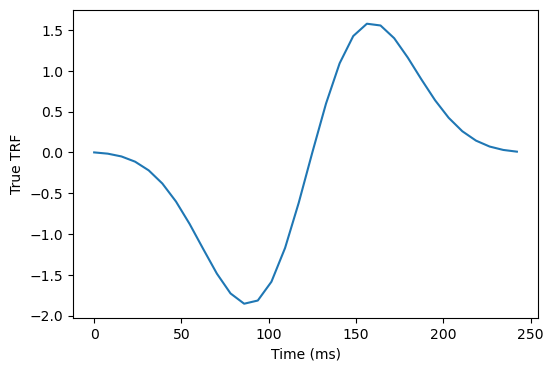

In [4]:
### Generate a target signal
# This approximately creates an N1-P2-like TRF, with a negativity around 100 ms and a positivity around 150 ms
sfreq = 128
trf_freq = 4 # modulation frequency of the TRF (will aim for a signal with an N100 and P200, approximately)
nchan = 1 # number of EEG channels
trf_dur = 250 # duration of the TRF, in ms
wnd_std = trf_dur/1000*sfreq/8 # standard deviation of the gaussian window, in indexes
    # the /6 at the end ensures the standard deviation is 1/8 of the full trf duration

t = np.arange(0,trf_dur/1000,1/sfreq) # time array
wnd = sp.signal.windows.gaussian(len(t),trf_dur/1000*sfreq/6) # gaussian window for the signal
true_trf = -np.sin(2*np.pi*t*trf_freq) * wnd
true_trf = (true_trf)/np.std(true_trf) # normalize the true trf amplitude

# Plot the signal
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(t*1000,true_trf)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('True TRF')


In [5]:
# Load the natural speech data
natspeech_fn = 'natural_speech_stim.pkl'
with open(natspeech_fn,'rb') as file:
    natsp_data = pickle.load(file)

envelope = natsp_data['envelope']
natsp_fs = natsp_data['fs']

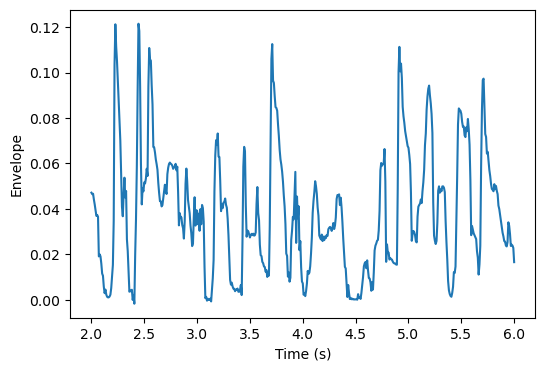

In [6]:
time_range = (2,6) # range of times for the plot of the envelope, in s

fig, ax = plt.subplots(figsize=(6,4))
env_idx = np.arange(0,envelope[0].shape[0])
t_env = env_idx/sfreq
idx = (t_env>=time_range[0]) & (t_env<=time_range[1])
ax.plot(t_env[idx],np.ravel(envelope[0])[idx])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Envelope')
plt.show()
#plt.savefig('fig/ExmpSpeechEnv.eps')

In [10]:
### Load stimulus data and convolve with the TRF
# Allow the user to upload stimulus data
ntrials = len(envelope) # number of trials
###trial_dur = 60 # trial duration (s)
### The natural speech dataset only has 20 trials, each 3 minutes long (total ~60 minutes)
### Maybe concatenate the simulated responses and chunk
tidx = [int(ti*sfreq) for ti in t]
print(true_trf.shape)

sim_resp = []
for env in envelope:
    X = mtrf.model.lag_matrix(env,tidx)
    print(X.shape)
    sim_resp.append(np.matmul(X[:,1:],true_trf))



#x = [np.convolve(np.ravel(env),true_trf) for env in envelope]

# remove indexes at the start corresponding to negative delays in the TRF


(32,)
(22729, 33)
(23130, 33)
(23050, 33)
(23213, 33)
(23082, 33)
(25873, 33)
(21213, 33)
(21899, 33)
(22521, 33)
(24699, 33)
(22473, 33)
(23011, 33)
(23451, 33)
(22839, 33)
(23469, 33)
(23822, 33)
(23998, 33)
(23189, 33)
(22711, 33)
(24200, 33)


In [ ]:
print(tidx)

In [ ]:
print(x[0].shape)
print(idx.shape)

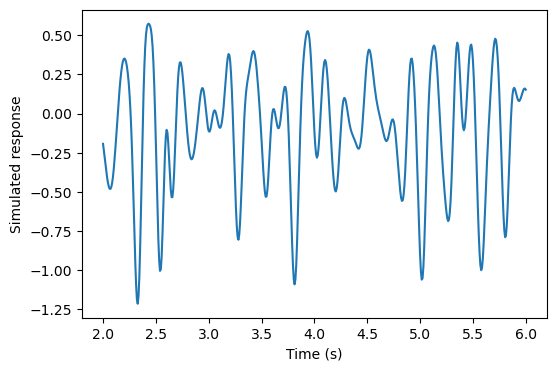

In [12]:
# Plot one of the example simulated responses
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(t_env[idx],sim_resp[0][idx])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Simulated response')
plt.show()

Text(0.5, 1.0, 'Example EEG data (applied for noise)')

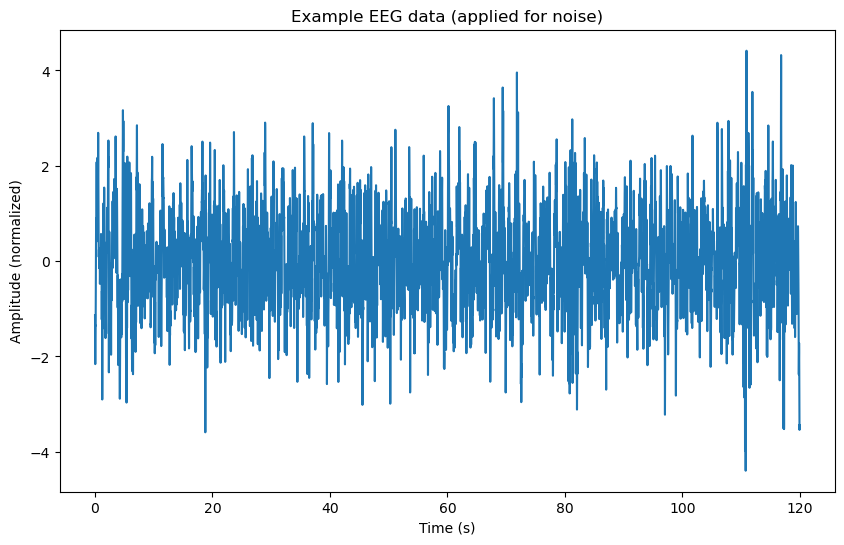

In [13]:
### Create EEG-shaped noise

# zero-center and normalize the example EEG data
exmp_eeg = (exmp_eeg-np.mean(exmp_eeg))/np.std(exmp_eeg)

fig, ax = plt.subplots(figsize=(10,6))
exmp_time = np.reshape(np.arange(0,exmp_eeg.shape[0])/exmp_fs,(exmp_eeg.shape[0],1))
ax.plot(exmp_time,exmp_eeg)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (normalized)')
ax.set_title('Example EEG data (applied for noise)')

In [ ]:
### Add EEG-shaped noise to the signal
# Fourier Transform
fft_exmp_eeg = np.fft.rfft(exmp_eeg)

In [ ]:
# Setup the parameters for the simulations
SNR = np.arange(-40,-5,5) # range of signal-to-noise ratios, in dB
ntr = np.arange(4,4,len(sim_resp)) # number of trials used (3 minutes each)
nrep = 10 # number of repetitions for each simulation

In [ ]:
results = []
### Estimate the TRF using leave-one-out cross-validation
for s in SNR:
    for n in ntr:
        for ii in nrep:
            # randomize the EEG phase to create noise
            # Randomize phases
            random_phases = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(fft_exmp_eeg)))
            randomized_fft_signal = np.abs(fft_exmp_eeg) * random_phases

            # Inverse Fourier Transform
            rnd_exmp_eeg = np.fft.irfft(randomized_fft_signal)

            # Normalize the standard deviation of rnd_exmp_eeg
            rnd_exmp_eeg = rnd_exmp_eeg / np.std(rnd_exmp_eeg)
            
            # create the example data by adding noise
            resp = [x*SNR[s] + rnd_eeg for x in sim_resp]

            # run TRF analysis
            
            # save the results

In [ ]:
### Create a null distribution of prediction accuracies

In [ ]:
### Plot prediction accuracy (both r and MSE) as a function of the amount of data and SNR

In [ ]:
### Plot estimated TRF vs actual TRF as a function of the amount of data and SNR